In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os, time, random, pickle, warnings
from tqdm import tqdm

from pydicom import dcmread
from utils.image_viz import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# File paths
DATASET_PATH                = f'dataset/ALL'
DICOM_PATH                  = f'{DATASET_PATH}/T2SAG_SLICES=7'
LABEL_FILENAME              = f'{DATASET_PATH}/Labels_Final.csv'

# Predefined variables
BBOX_COL_NAME               = ['x_top_lt', 'y_top_lt', 'x_bot_rt', 'y_bot_rt']
DESIRED_SHAPE_CV            = (112, 224)

# **Load Labels**

In [3]:
# Load labeled dataset
df = pd.read_csv(LABEL_FILENAME)
df['patient_id'] = df['patient_id'].apply(lambda x: f'{x:08d}')
df[BBOX_COL_NAME] = df[BBOX_COL_NAME].astype(int)

df.set_index('patient_id', inplace=True)
df

,sex,age,date_xr,date_diff,label,x_top_lt,y_top_lt,x_bot_rt,y_bot_rt
patient_id,,,,,,,,,
35746667,M,44,20070123,4,1,179,8,317,284
35870452,F,76,20070124,18,0,465,234,752,808
20085353,M,49,20070122,0,1,219,150,362,436
28227555,F,63,20070125,41,1,224,106,377,412
21645107,F,49,20200410,4,1,163,89,278,319
...,...,...,...,...,...,...,...,...,...
50020155,F,67,20221230,3,1,211,127,349,403
57193009,F,62,20221228,1,1,253,96,491,572
50183621,M,77,20221227,45,1,179,66,337,382


# **DICOM File to Image**

In [4]:
def dicom_to_array(filename):
    # ==================================================
    # Input(s)
    # - filename[string]    : DICOM(.dcm) file to read
    #
    # Output(s)
    # - image[np.array]     : NumPy array of pixel range [0, 1]
    # ==================================================
    assert os.path.isfile(filename), f'[NO FILE] {filename}'
    dicom = dcmread(open(filename, 'rb'))
    
    image = dicom.pixel_array
    min, max = np.min(image), np.max(image)
    image = (image - min) / (max - min)
    image = image[..., np.newaxis]
    
    return image

In [5]:
def cropped_image(patient_id, dicom_idx):
    dicom_filename = f'{DICOM_PATH}/{patient_id}/{dicom_idx}.dcm'
    image = dicom_to_array(dicom_filename)

    x_top_lt = df.loc[patient_id, 'x_top_lt']
    y_top_lt = df.loc[patient_id, 'y_top_lt']
    x_bot_rt = df.loc[patient_id, 'x_bot_rt']
    y_bot_rt = df.loc[patient_id, 'y_bot_rt']

    image = image[y_top_lt:y_bot_rt, x_top_lt:x_bot_rt]
    image = cv2.resize(image, DESIRED_SHAPE_CV)

    return image

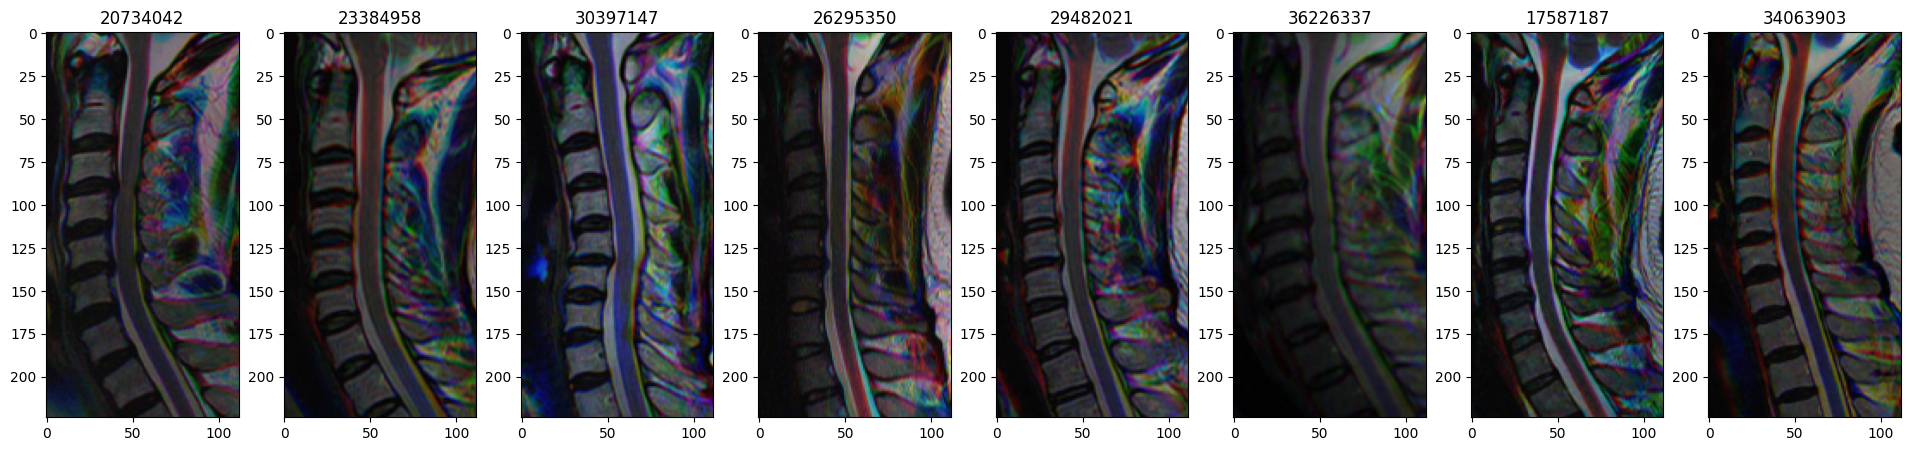

In [6]:
images, labels = [], []
for patient_id in df.index[100:108]:
    image = np.stack([cropped_image(patient_id, idx) for idx in [2, 3, 4]], axis=-1)

    images.append(image)
    labels.append(patient_id)

ShowImages(images, labels, figsize=(3, 5), ncols=8)

# **Create Dataset**

* Dataset shape : (n_samples, 224, 112, 3)

* Pixel values : [0, 1]

In [7]:
DATASET_FILENAME = f'{DATASET_PATH}/dataset.pkl'
dataset = {'X_tval': None, 'y_tval': None, 'X_test': None, 'y_test': None}

for key in ['tval', 'test']:
    PATIENT_ID_FILENAME = f'{DATASET_PATH}/patient_id_{key}.pkl'
    patient_id_list = pickle.load(open(PATIENT_ID_FILENAME, 'rb'))

    X, y = [], []
    for patient_id in tqdm(patient_id_list):
        image = np.stack([cropped_image(patient_id, idx) for idx in [2, 3, 4]], axis=-1)
        label = df.loc[patient_id, 'label']

        X.append(image)
        y.append(label)

    dataset[f'X_{key}'] = np.uint8(np.array(X) * 255)
    dataset[f'y_{key}'] = np.array(y)

print('\nCreated dataset...')
print(dataset['X_tval'].shape, dataset['y_tval'].shape)
print(dataset['X_test'].shape, dataset['y_test'].shape)

print('\nSaving dataset to [dataset.pkl] ...')
pickle.dump(dataset, open(DATASET_FILENAME, 'wb'))

print('Done')

100%|██████████| 765/765 [00:04<00:00, 183.94it/s]



Created dataset...
(6880, 224, 112, 3) (6880,)
(765, 224, 112, 3) (765,)

Saving dataset to [dataset.pkl] ...
Done
